In [1]:
import torch
print(torch.__version__)

1.13.0


In [2]:
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./CIFAR10', train=False,
                                       download=True, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, 
                                        shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


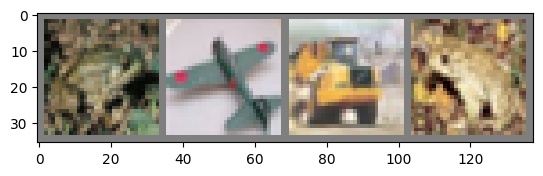

frog  plane truck frog 
<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([4])


In [7]:
# functions to show an image

batch_size = 4
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
print(type(images), images.shape)
print(type(labels), labels.shape)

In [8]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):
        super(MLP, self).__init__()
        self.in_dim= in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act

        self.fc = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()

        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
        self.fc2 = nn.Linear(self.hid_dim,self.out_dim)
        
        if self.act=='relu':
            self.act = nn.ReLU()        

    def forward(self, x):
        x = self.act(self.fc(x))
        for fc in self.linears:
            x = self.act(fc(x))
        x = self.fc2(x)
        return x

model = MLP(3*32*32, 10, 128, 3, 'relu')

In [9]:
print(model)

MLP(
  (fc): Linear(in_features=3072, out_features=128, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (act): ReLU()
)


In [10]:


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
# training step
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.162
[1,  4000] loss: 1.878
[1,  6000] loss: 1.787
[1,  8000] loss: 1.699
[1, 10000] loss: 1.664
[2,  2000] loss: 1.591
[2,  4000] loss: 1.570
[2,  6000] loss: 1.530
[2,  8000] loss: 1.532
[2, 10000] loss: 1.509
Finished Training


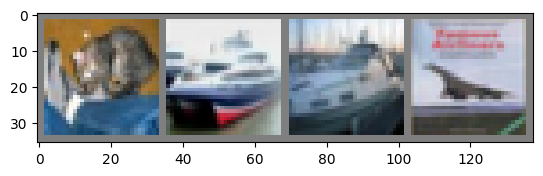

GroundTruth:  cat   ship  ship  plane


In [14]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [20]:
# measure validation acc & loss
correct = 0
total = 0
val_loss = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valloader:
        images, labels = data
        images = images.view(-1, 3072)
        # calculate outputs by running images through the network
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    val_loss = val_loss / len(valloader)
acc = 100 * correct / total
print('Accuracy and loss of the network on the 10000 test images: Acc:: {:2.2f} , Loss :: {:2.2f}'.format(acc, val_loss))

Accuracy and loss of the network on the 10000 test images: Acc:: 47.42 , Loss :: 1.49


In [ ]:
# measure test acc
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.view(-1, 3072)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    test_acc = 100 * correct // total

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

## Experiment code lines with function call

In [4]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):
        super(MLP, self).__init__()
        self.in_dim= in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act

        self.fc = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()

        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
        self.fc2 = nn.Linear(self.hid_dim,self.out_dim)
        
        if self.act=='relu':
            self.act = nn.ReLU()        

    def forward(self, x):
        x = self.act(self.fc(x))
        for fc in self.linears:
            x = self.act(fc(x))
        x = self.fc2(x)
        return x

In [5]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")

# hyperparameter set
args.n_layer = 5
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'
args.lr = 0.001
args.mm = 0.9
args.epochs = 32
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [6]:
def experiment(args):
    step_results = {}
    step_results['Train_Loss'] = list()
    step_results['Val_Loss'] = list()
    step_results['Val_Acc'] = list()


    mps_device = torch.device("mps")
    model = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
    print(model)
    model.to(mps_device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.mm)
        
    
    for epoch in range(args.epochs):  # loop over the dataset multiple times
        # ==== training step
        running_loss = 0.0
        train_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(mps_device)
            labels = labels.to(mps_device)
            inputs = inputs.view(-1, 3072)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # print statistics
        running_loss += loss.item()
        train_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

        # ==== validation step
        # measure validation acc & loss
        correct = 0
        total = 0
        val_loss = 0
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images = images.to(mps_device)
                labels = labels.to(mps_device)
                images = images.view(-1, 3072)
                # calculate outputs by running images through the network
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
        print('Epoch : {}, Train Loss : {:2.2f}, Val Loss : {:2.2f}, Val Acc : {:2.2f}'.format(epoch+1, train_loss, val_loss, val_acc))
        step_results['Train_Loss'].append(train_loss)
        step_results['Val_Loss'].append(val_loss)
        step_results['Val_Acc'].append(val_acc)

    # === Evaluation for test set
    # measure test acc
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(mps_device)
            labels = labels.to(mps_device)
            images = images.view(-1, 3072)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct // total

    
    print('Test acc : {:2.2f}'.format(test_acc))
        
    return step_results , test_acc

In [9]:
args

Namespace(n_layer=5, in_dim=3072, out_dim=10, hid_dim=100, act='relu', lr=0.001, mm=0.9, epochs=32)

In [8]:
spec_in_training, test_acc = experiment(args)

MLP(
  (fc): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)
Epoch : 1, Train Loss : 2.28, Val Loss : 2.28, Val Acc : 19.79
Epoch : 2, Train Loss : 1.96, Val Loss : 2.03, Val Acc : 23.81
Epoch : 3, Train Loss : 1.80, Val Loss : 1.89, Val Acc : 30.07
Epoch : 4, Train Loss : 1.94, Val Loss : 1.80, Val Acc : 34.13
Epoch : 5, Train Loss : 1.89, Val Loss : 1.71, Val Acc : 38.77
Epoch : 6, Train Loss : 1.47, Val Loss : 1.62, Val Acc : 41.90
Epoch : 7, Train Loss : 1.59, Val Loss : 1.58, Val Acc : 43.21
Epoch : 8, Train Loss : 1.65, Val Loss : 1.53, Val Acc : 44.84
Epoch : 9, Train Loss : 1.35, Val Loss : 1.50, Val Acc : 46.53
Epoch : 10

In [12]:
spec_in_training['args'] = args

In [14]:
# hyperparameter set
# different layer architecture
args.n_layer = 3
args.hid_dim = 1024
args.act = 'relu'
args.lr = 0.001
args.mm = 0.9
args.epochs = 32
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [15]:
args

Namespace(n_layer=3, in_dim=3072, out_dim=10, hid_dim=1024, act='relu', lr=0.001, mm=0.9, epochs=32)

In [16]:
spec_in_training2, test_acc2 = experiment(args)
spec_in_training['args'] = args

MLP(
  (fc): Linear(in_features=3072, out_features=1024, bias=True)
  (linears): ModuleList(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
  (act): ReLU()
)
Epoch : 1, Train Loss : 1.93, Val Loss : 1.85, Val Acc : 34.53
Epoch : 2, Train Loss : 1.63, Val Loss : 1.67, Val Acc : 40.70
Epoch : 3, Train Loss : 1.54, Val Loss : 1.55, Val Acc : 45.08
Epoch : 4, Train Loss : 1.23, Val Loss : 1.48, Val Acc : 48.29
Epoch : 5, Train Loss : 1.67, Val Loss : 1.43, Val Acc : 49.83
Epoch : 6, Train Loss : 1.67, Val Loss : 1.43, Val Acc : 49.95
Epoch : 7, Train Loss : 1.20, Val Loss : 1.37, Val Acc : 52.16
Epoch : 8, Train Loss : 1.84, Val Loss : 1.38, Val Acc : 51.88
Epoch : 9, Train Loss : 1.18, Val Loss : 1.37, Val Acc : 52.29
Epoch : 10, Train Loss : 1.07, Val Loss : 1.37, Val Acc : 52.82
Epoch : 11, Train Loss : 0.91, Val Loss : 1.37, Val Acc : 52.83
